In [1]:
import numpy as np
import pandas as pd

from etl import load_monsters, _mechanics, _stats, _flavor, _skills, get_monster_df

# Load data

In [2]:
monsters, ogl = load_monsters()
monster_df = get_monster_df(monsters)

In [3]:
monster_df[_mechanics]

,challenge_rating,armor_class,hit_dice,hit_points,condition_immunities,damage_immunities,damage_resistances,damage_vulnerabilities,actions,reactions,legendary_actions,special_abilities,size,speed,senses
name,,,,,,,,,,,,,,,
Aboleth,10.00,17,18d10,135,,,,,"[{'name': 'Multiattack', 'desc': 'The aboleth ...",[],"[{'name': 'Detect', 'desc': 'The aboleth makes...","[{'name': 'Amphibious', 'desc': 'The aboleth c...",Large,"10 ft., swim 40 ft.","darkvision 120 ft., passive Perception 20"
Acolyte,0.25,10,2d8,9,,,,,"[{'name': 'Club', 'desc': 'Melee Weapon Attack...",[],[],"[{'name': 'Spellcasting', 'desc': 'The acolyte...",Medium,30 ft.,passive Perception 12
Adult Black Dragon,14.00,19,17d12,195,,acid,,,"[{'name': 'Multiattack', 'desc': 'The dragon c...",[],"[{'name': 'Detect', 'desc': 'The dragon makes ...","[{'name': 'Amphibious', 'desc': 'The dragon ca...",Huge,"40 ft., fly 80 ft., swim 40 ft.","blindsight 60 ft., darkvision 120 ft., passive..."
Adult Blue Dracolich,17.00,19,18d12,225,"charmed, exhaustion, frightened, paralyzed, po...","lightning, poison",necrotic,,"[{'name': 'Multiattack', 'desc': 'The dracolic...",[],"[{'name': 'Detect', 'desc': 'The dracolich mak...","[{'name': 'Legendary Resistance (3/Day)', 'des...",Huge,"40 ft., burrow 30 ft., fly 80 ft.","blindsight 60 ft., darkvision 120 ft., passive..."
Adult Blue Dragon,16.00,19,18d12,225,,lightning,,,"[{'name': 'Multiattack', 'desc': 'The dragon c...",[],"[{'name': 'Detect', 'desc': 'The dragon makes ...","[{'name': 'Legendary Resistance (3/Day)', 'des...",Huge,"40 ft., burrow 30 ft., fly 80 ft.","blindsight 60 ft., darkvision 120 ft., passive..."
Adult Brass Dragon,13.00,18,15d12,172,,fire,,,"[{'name': 'Multiattack', 'desc': 'The dragon c...",[],[],"[{'name': 'Legendary Resistance (3/Day)', 'des...",Huge,"40 ft., burrow 40 ft., fly 80 ft.","blindsight 60 ft., darkvision 120 ft., passive..."
Adult Bronze Dragon,15.00,19,17d12,212,,lightning,,,"[{'name': 'Multiattack', 'desc': 'The dragon c...",[],"[{'name': 'Detect', 'desc': 'The dragon makes ...","[{'name': 'Amphibious', 'desc': 'The dragon ca...",Huge,"40 ft., fly 80 ft., swim 40 ft.","blindsight 60 ft., darkvision 120 ft., passive..."
Adult Copper Dragon,14.00,18,16d12,184,,acid,,,"[{'name': 'Multiattack', 'desc': 'The dragon c...",[],"[{'name': 'Detect', 'desc': 'The dragon makes ...","[{'name': 'Legendary Resistance (3/Day)', 'des...",Huge,"40 ft., climb 40 ft., fly 80 ft.","blindsight 60 ft., darkvision 120 ft., passive..."
Adult Gold Dragon,17.00,19,19d12,256,,fire,,,"[{'name': 'Multiattack', 'desc': 'The dragon c...",[],"[{'name': 'Detect', 'desc': 'The dragon makes ...","[{'name': 'Amphibious', 'desc': 'The dragon ca...",Huge,"40 ft., fly 80 ft., swim 40 ft.","blindsight 60 ft., darkvision 120 ft., passive..."


# Initial visualizations

In [4]:
from plotnine import aes, geom_boxplot, geom_point, ggplot, theme_bw, theme, geom_text, element_text


/Users/jason/Code/cr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


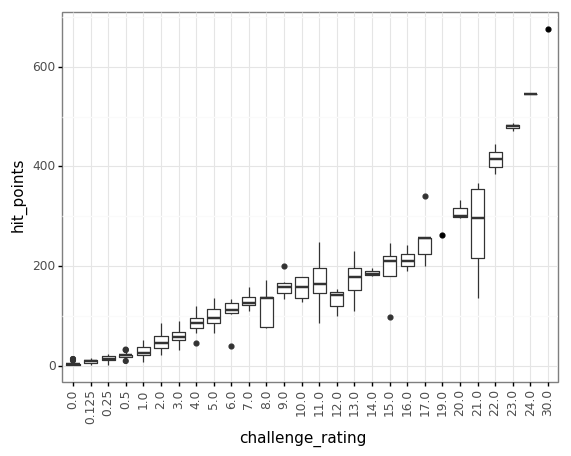

<ggplot: (-9223372036574722630)>

In [5]:
df = pd.DataFrame.copy(monster_df)
df.challenge_rating= df.challenge_rating.astype('category')

# I should automate this bit
# due to a matplotlib bug, plotnine doesn't handle categoricals with one datapoint gracefully
counts = df.challenge_rating.groupby(df.challenge_rating).count().rename('count')
singletons = [x for x in counts.index[counts == 1]]
a = df[df.challenge_rating.apply(lambda x: x not in singletons)]
b = df[df.challenge_rating.apply(lambda x: x in singletons)]

ggplot(a, aes(x='challenge_rating', y='hit_points')) + geom_boxplot() \
    + geom_point(b, aes(x='challenge_rating', y='hit_points')) + theme_bw() \
    + theme(axis_text_x=element_text(angle=90))

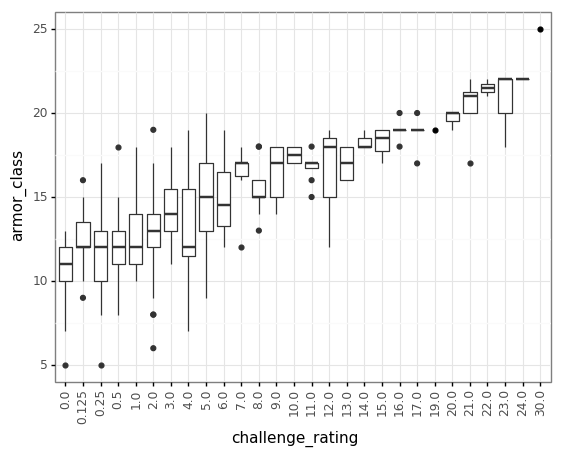

<ggplot: (-9223372036574726705)>

In [6]:
ggplot(a, aes(x='challenge_rating', y='armor_class')) + geom_boxplot() \
    + geom_point(b, aes(x='challenge_rating', y='armor_class')) + theme_bw() \
    + theme(axis_text_x=element_text(angle=90))

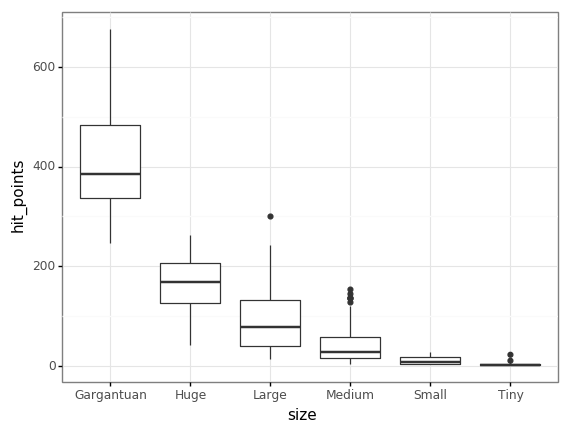

<ggplot: (-9223372036574321222)>

In [7]:
ggplot(df, aes(x='size', y='hit_points')) + geom_boxplot() + theme_bw()

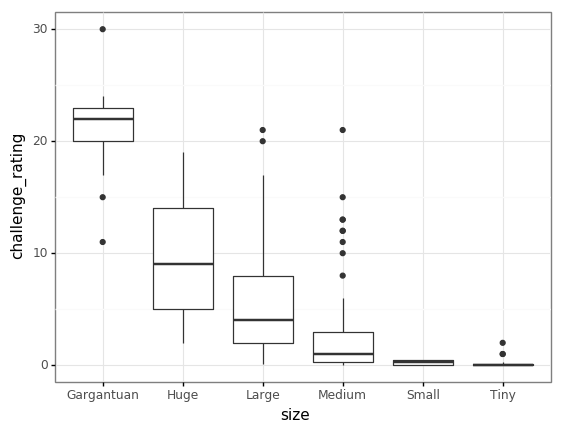

<ggplot: (-9223372036574204577)>

In [8]:
ggplot(monster_df, aes(x='size', y='challenge_rating')) + geom_boxplot() + theme_bw()

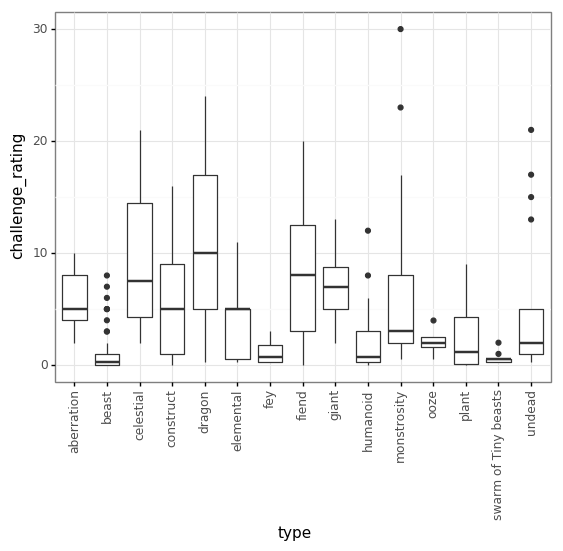

<ggplot: (-9223372036574087364)>

In [9]:
ggplot(monster_df, aes(x='type', y='challenge_rating')) + geom_boxplot() \
    + theme_bw() + theme(axis_text_x=element_text(angle=90))

# Feature extraction

In [10]:
from functools import reduce
actions_keys = {tuple(action.keys()) for actions in monster_df.actions for action in actions}
actions_keys

{('name', 'desc', 'attack_bonus'),
 ('name', 'desc', 'attack_bonus', 'damage_bonus'),
 ('name', 'desc', 'attack_bonus', 'damage_dice'),
 ('name', 'desc', 'attack_bonus', 'damage_dice', 'damage_bonus')}

In [11]:
from functools import partial

def has_properties(x, pos=[], neg=[]):
    return any(all([z in y for z in pos] + [z not in y for z in neg]) for y in x)

In [12]:
from collections import namedtuple
import re

get_dc = partial(re.findall,
                 re.compile(r'\bDC (\d+) (' \
                            + r'|'.join(stat.capitalize() for stat in _stats) \
                            + r')\b'))

get_dice = partial(re.findall, re.compile(r'\b(\d+)?d(\d+)\b'))


def parse_actions(actions):
    multi = False
    for action in actions:
        if action['name'] == 'Multiattack':
            multi = True
            continue
        attack_bonus = action.get('attack_bonus', 0)
        damage_bonus = action.get('damage_bonus', 0)
        damage_dice = action.get('damage_dice', '')
        dcs = get_dc(action.get('desc'))
    return multi, attack_bonus, damage_bonus, damage_dice, dcs

In [13]:
neg=['damage_dice', 'damage_bonus']
def has_special_action(actions):
    return any(is_special_action(action) for action in actions)

def is_special_action(action):
    return 'Multiattack' not in action['name'] and all([z not in action for z in neg])

def get_special_action(actions):
    return [action for action in actions if is_special_action(action)]

monster_df.actions[monster_df.actions.apply(has_special_action)].apply(get_special_action)

name
Aboleth                  [{'name': 'Enslave (3/day)', 'desc': 'The abol...
Adult Black Dragon       [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Blue Dracolich     [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Blue Dragon        [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Brass Dragon       [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Bronze Dragon      [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Copper Dragon      [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Gold Dragon        [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Green Dragon       [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Red Dragon         [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Silver Dragon      [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult White Dragon       [{'name': 'Frightful Presence', 'desc': 'Each ...
Air Elemental            [{'name': 'Whirlwind (Recharge 4-6)', 'desc': ...
Ancient Black Dragon

In [14]:
monster_df.loc['Wereboar'].actions

[{'attack_bonus': 0,
  'desc': 'The wereboar makes two attacks, only one of which can be with its tusks.',
  'name': 'Multiattack (Humanoid or Hybrid Form Only)'},
 {'attack_bonus': 5,
  'damage_bonus': 3,
  'damage_dice': '2d6',
  'desc': 'Melee Weapon Attack: +5 to hit, reach 5 ft., one target. Hit: 10 (2d6 + 3) bludgeoning damage.',
  'name': 'Maul (Humanoid or Hybrid Form Only)'},
 {'attack_bonus': 5,
  'damage_bonus': 3,
  'damage_dice': '2d6',
  'desc': 'Melee Weapon Attack: +5 to hit, reach 5 ft., one target. Hit: 10 (2d6 + 3) slashing damage. If the target is a humanoid, it must succeed on a DC 12 Constitution saving throw or be cursed with wereboar lycanthropy.',
  'name': 'Tusks (Boar or Hybrid Form Only)'}]

In [15]:
f = partial(has_properties, pos=['damage_bonus'], neg=['damage_dice'])

monster_df.actions[monster_df.actions.apply(f)]

name
Badger             [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Bat                [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Cat                [{'name': 'Claws', 'desc': 'Melee Weapon Attac...
Crab               [{'name': 'Claw', 'desc': 'Melee Weapon Attack...
Flying Snake       [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Hawk               [{'name': 'Talons', 'desc': 'Melee Weapon Atta...
Homunculus         [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Lizard             [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Octopus            [{'name': 'Tentacles', 'desc': 'Melee Weapon A...
Owl                [{'name': 'Talons', 'desc': 'Melee Weapon Atta...
Poisonous Snake    [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Quipper            [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Rat                [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Scorpion           [{'name': 'Sting', 'desc': 'Melee Weapon Attac...
Spider             [{'name': 

In [16]:
monster_df.actions['Rat']

[{'attack_bonus': 0,
  'damage_bonus': 1,
  'desc': 'Melee Weapon Attack: +0 to hit, reach 5 ft., one target. Hit: 1 piercing damage.',
  'name': 'Bite'}]

In [17]:
get_dc(monster_df.actions[0][3]['desc'])

[('14', 'Wisdom')]

In [18]:
monster_df.reactions[monster_df['reactions'].apply(lambda x: len(x) > 0)]

name
Bandit Captain     [{'name': 'Parry', 'desc': 'The captain adds 2...
Black Pudding      [{'name': 'Split', 'desc': 'When a pudding tha...
Chain Devil        [{'name': 'Unnerving Mask', 'desc': 'When a cr...
Erinyes            [{'name': 'Parry', 'desc': 'The erinyes adds 4...
Gladiator          [{'name': 'Parry', 'desc': 'The gladiator adds...
Knight             [{'name': 'Parry', 'desc': 'The knight adds 2 ...
Marilith           [{'name': 'Parry', 'desc': 'The marilith adds ...
Noble              [{'name': 'Parry', 'desc': 'The noble adds 2 t...
Ochre Jelly        [{'name': 'Split', 'desc': 'When a jelly that ...
Shield Guardian    [{'name': 'Shield', 'desc': 'When a creature m...
Stone Giant        [{'name': 'Rock Catching', 'desc': 'If a rock ...
Name: reactions, dtype: object

In [19]:
from functools import partial, reduce

def string_to_list(x, sep=','):
    return [y.strip() for y in x.split(sep)]


def concat(lists):
    return reduce(lambda x, y: x + y, lists, [])


def get_unique_values(series, sep=','):
    lists = series.apply(partial(string_to_list, sep=sep))
    values = concat(lists)
    return sorted(v for v in set(values) if v)

In [20]:
condition_immunities = get_unique_values(monster_df.condition_immunities)
damage_immunities = get_unique_values(monster_df.damage_immunities, sep=';')
damage_resistances = get_unique_values(monster_df.damage_resistances, sep=';')
damage_vulnerabilities = get_unique_values(monster_df.damage_vulnerabilities)